# Изучение особенностей работы со слоями НС в `PyTorch`
<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1k5ih-FSbCTuErwBHHi3J3uCN1q4fRzFI) -->

Часто при работе с нейронными сетями возникает проблема загрузки тех или иных данных в типичные архитектуры слоев. Таких архитектур можно перечислить минимум 4:
* полносвязный слой.
* сверточный слой.
* рекуррентный слой.
* слой трансформер.

Каждый слой имеет свою специфику загрузки данных и работы с ними. Более того, эта специфика может зависеть и от рассматриваемой модальности данных. Неправильное понимание специфики слоя может привести к значительным ошибкам при его использовании. В свою очередь, это приводит к неверным результатам обучения моделей в целом. 

Данная практика посвящена особенностям работы со слоями в `PyTorch`.

Для более обширного изучения особенностей функционирования составных компонент нейронных сетей рекомендуются следующие ресурсы:
* https://nn.labml.ai/ - реализация компонент нейронных сетей `from scratch`.
* https://d2l.ai/ - интерактивная книга по Deep Learning с примерами реализации компонент.
* https://github.com/NVIDIA/DeepLearningExamples - уже не новые, но все еще актуальные примеры работы с нейронными сетями от NVIDIA.

## Импорт `torch`

In [52]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [53]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    
    


In [54]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.1
Using device: cpu
default data type: torch.float32
available number of workers: 4


# Предсказание значений временного ряда

## Проблема анализ временных рядов

Одним из наиболее показательных и в то же время не самым интуитивным является пример работы с временными рядами при помощи нейронных сетей. В первую очередь среди всех задач анализа временных рядов следует рассмотреть задачу будущих значений временного ряда. Рассмотрим пример классического временного ряда — число пассажиров на авиалиниях.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
# import ssl
# ssl._create_default_https_context = ssl._create_stdlib_context
# url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
# dataset = pd.read_csv(url, index_col='Month', parse_dates=True)
# print(dataset.head())

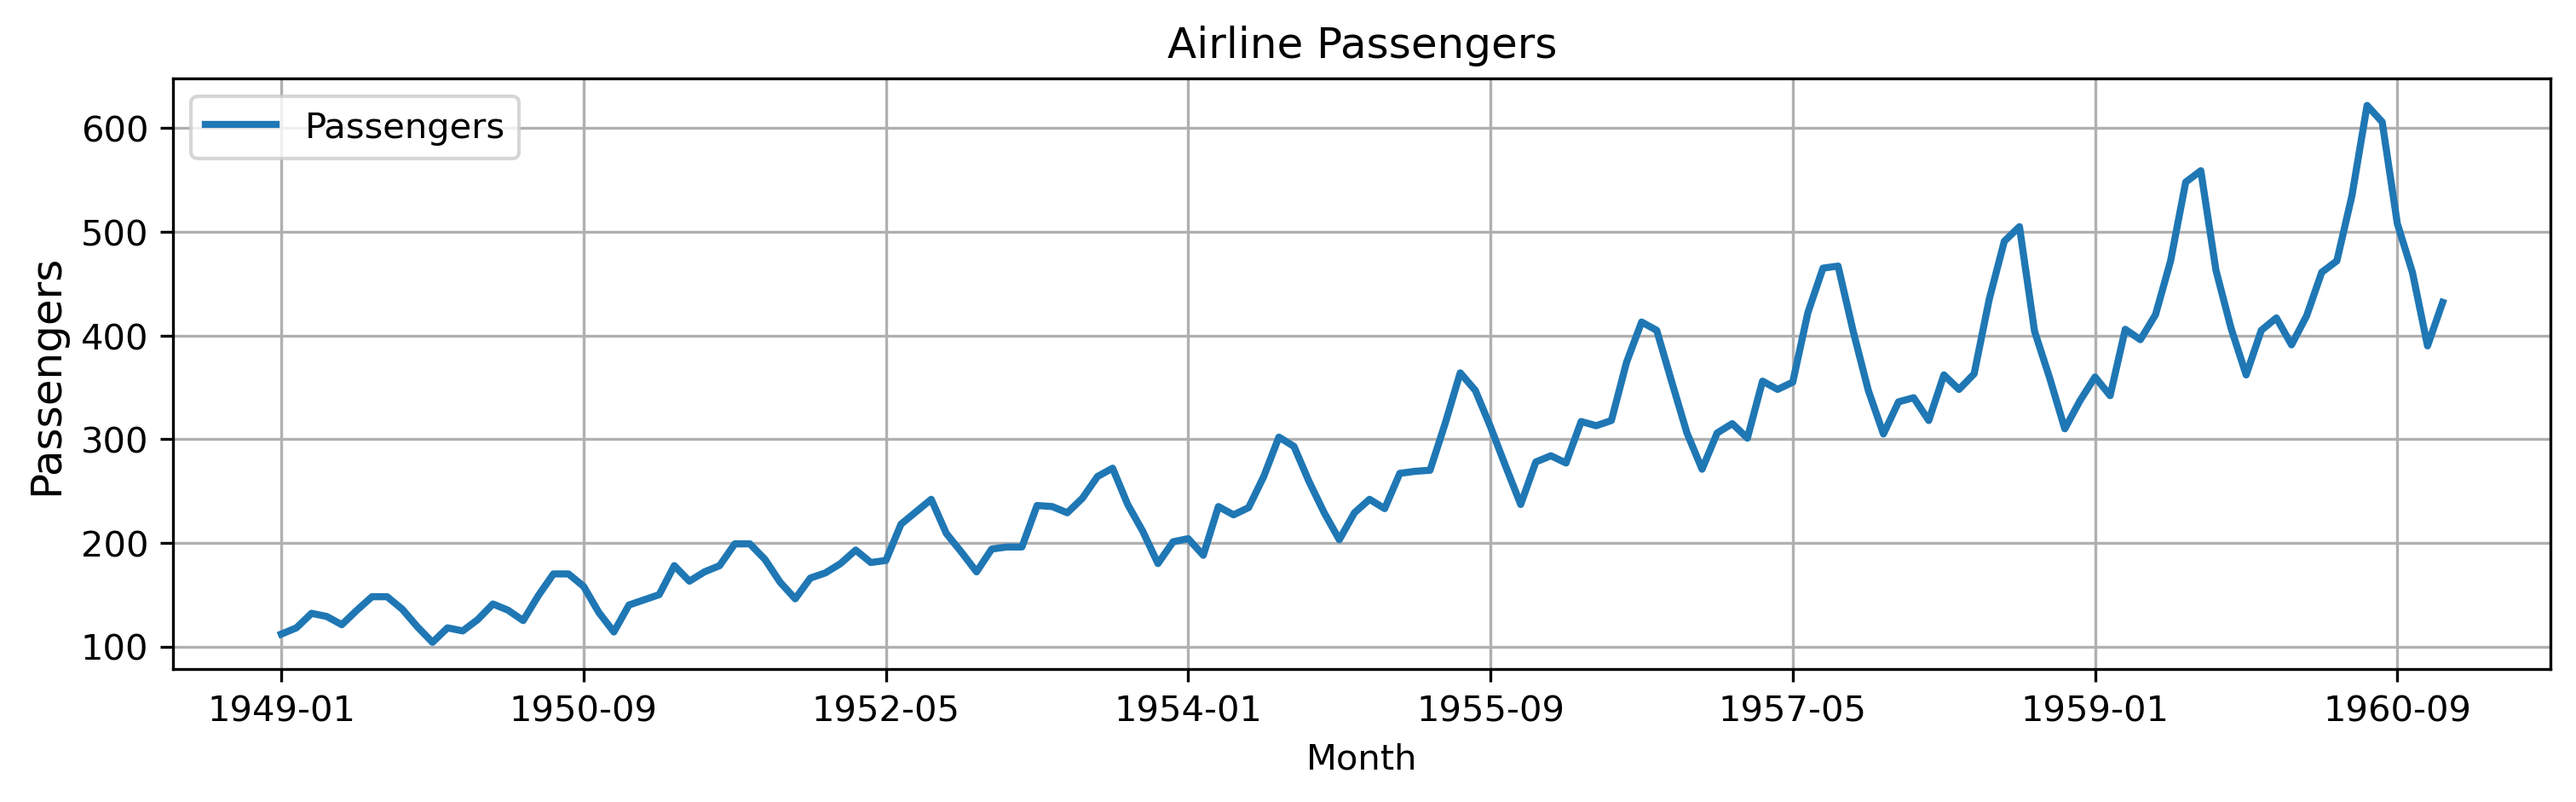

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('dataset/airline-passengers.csv')
fig,ax = plt.subplots(figsize=(12,3), dpi=300); df.plot(x = 'Month',ax=ax, linewidth=2)
plt.ylabel('Passengers', fontsize=12); plt.title('Airline Passengers'); plt.grid(); plt.show();

Видно, что анализируемый временной ряд имеет возрастающий тренд и сезонные изменения. Шаг записей в ряду 1 месяц. Пусть мы хотели бы спрогнозировать последний год из имеющихся данных, то есть выделим тестовую часть в размере 12 записей. Кроме того, нам необходимо выбрать, по какому периоду мы будем прогнозировать. Допустим, что прогноз будет строиться за период в 2 года (24 записи). Прогноз будем строить итерационно, месяц за месяцем. Другими словами, выбираем горизонт прогнозирования 1 месяц (1 запись). 

Таким образом, входные данные для нейронной сети должны иметь размер 24 месяца. Выходные данные будут иметь 1 значение. Тестовый период 12 значений. 

Разделим наш набор данных на тестовую (валидационную) часть в 1 год и тренировочную часть. Заметим, что для построения прогноза на 1 год нам потребуется окно данных перед диапазоном прогнозируемых значений. Поэтому формально тестовая выборка будет чуть шире. 

>Отметим, что на самом деле (если бы выборка была шире), то тестовый/валидационный период следовало бы выбирать как несколько целевых тестовых периодов (например, 3 года). Таким образом, можно было бы более точно оценить реальную точность. Более того, на практике необходимо было бы также оценить разброс значений, помимо их т. н. точечного значения.

> Отметим что ниже  проводится операция нормировки (`MinMaxScaler`) - эта операция необходима в первую очередь в рекуррентных ячейках, которые особенно не стабильны к нестационарности данных.

In [67]:
from sklearn.preprocessing import MinMaxScaler #https://encord.com/blog/time-series-predictions-with-recurrent-neural-networks/

scaler = MinMaxScaler()

data_ = np.atleast_2d(df.Passengers.values).T

 
TEST   = 12 
WINDOW = 24
HORIZON = 1


train = scaler.fit_transform(data_[:-TEST]).squeeze()
test = scaler.transform(data_[len(data_)-TEST-WINDOW:]).squeeze()
train.shape, test.shape

((132,), (36,))

Визуализируем разбивку данных

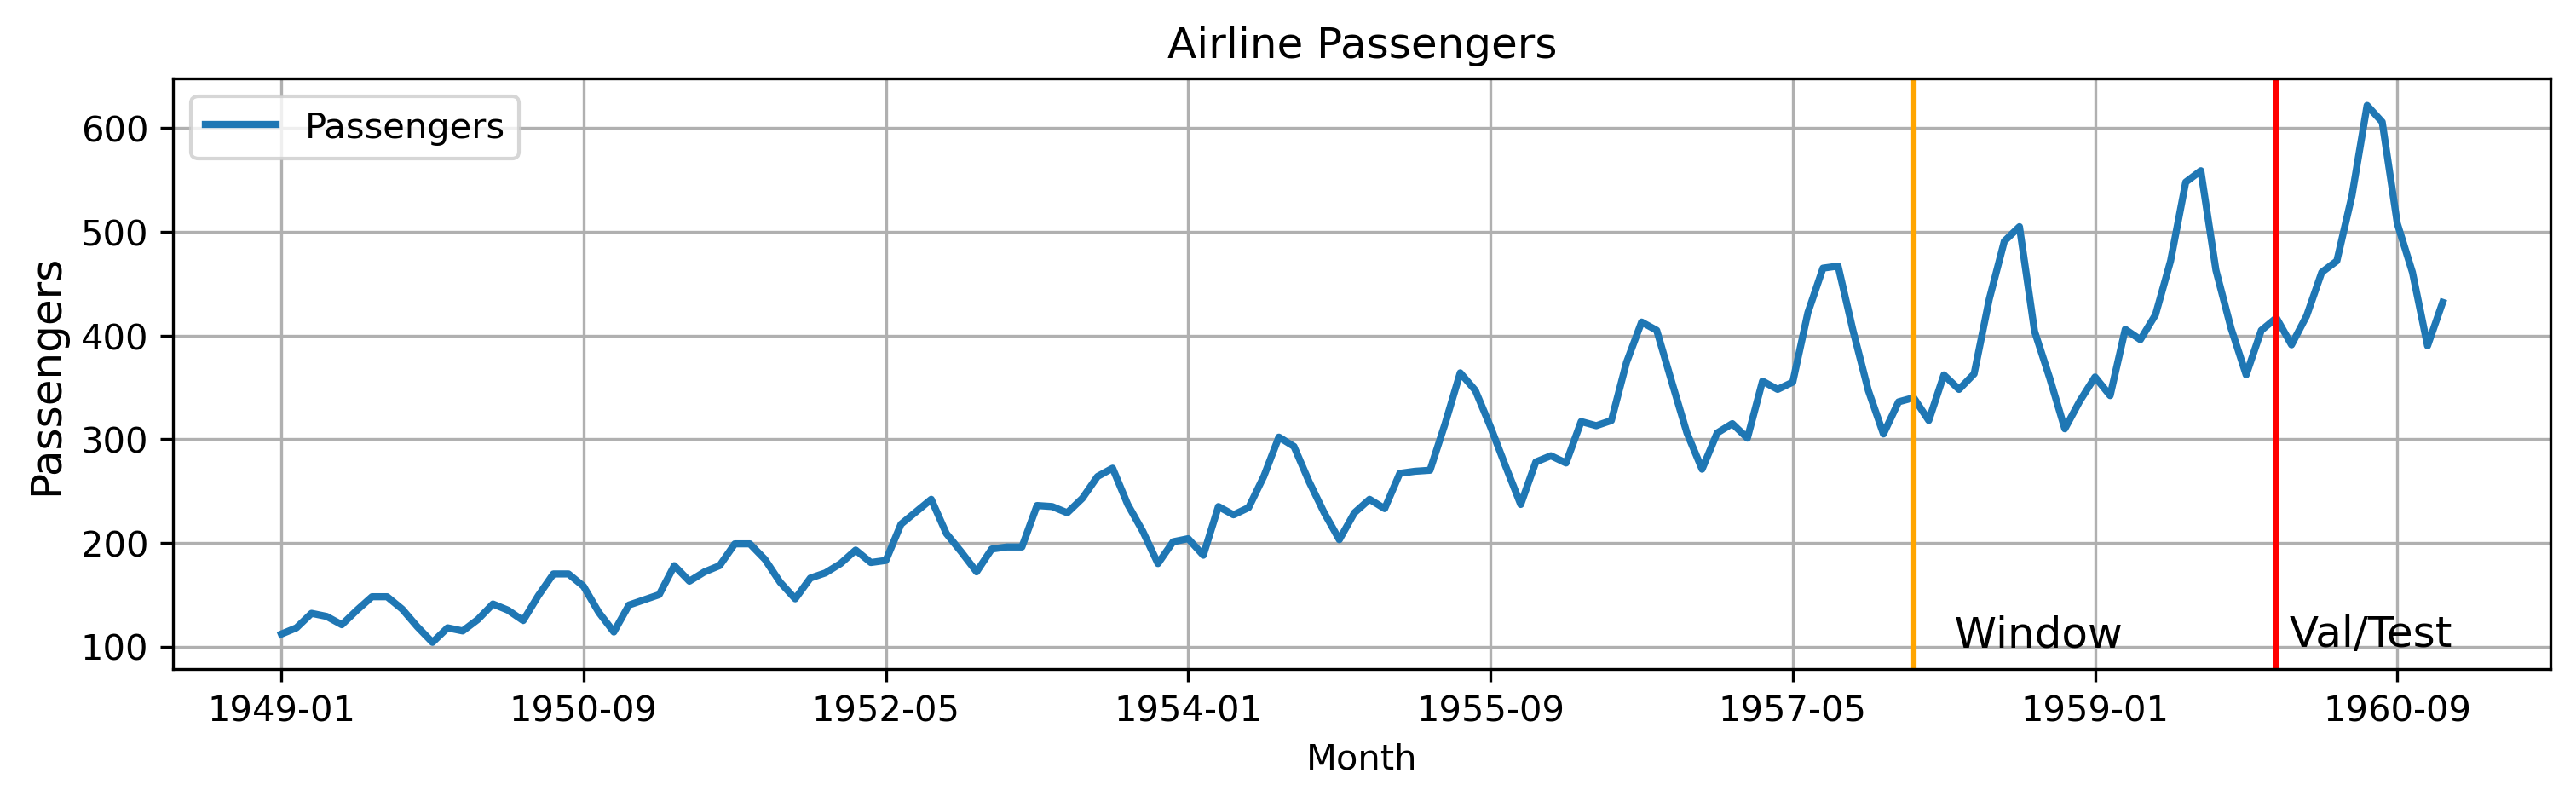

In [68]:
fig,ax = plt.subplots(figsize=(12,3), dpi=300); df.plot(ax=ax, x = 'Month', linewidth=2)
plt.axvline(len(train) , color='red'); plt.text(len(train), 100, ' Val/Test', fontsize=12)
plt.axvline(len(df)-len(test) , color='orange'); plt.text(len(df)-len(test), 100, '   Window', fontsize=12)

plt.ylabel('Passengers', fontsize=12); plt.title('Airline Passengers'); plt.grid(); plt.show();

Обратите внимание, что рассмотренная проблема предсказания не совсем одно и тоже, что типичная регрессионная проблема. Если в типичной задаче регрессии мы предсказываем какой-то параметр по входной выборке, то в нашем случае мы хотели бы предсказать будущее значение одной переменной по набору ее предыдущих значений. На практике это означает, что рано или поздно мы должны будем перейти к задаче предсказания будущих значений по предсказанным же предыдущим результатам. В этом смысле такую задачу называют авторегрессионной.

Решение авторегрессионных задач может быть выполнено классическими техниками. Однако, в рамках нашей дисциплины мы попробуем решить эту проблему при помощи нейронных сетей.

На самом деле, временной ряд не совсем подходит для использования напрямую в нейронных сетях. Удобней будет преобразовать проблему предсказания ВР в проблему табличной регрессии. Для этого рассмотрим каждое наше окно как запись в таблице (входные данные, `Х`). А следующее за окном значение как необходимый результат предсказания (целевую переменную, метку, `y`). Окно будем двигать с шагом в 1 значение. Такая матрица будет называться гусиничной. 
Рассмотрим, что это значит, на примере из 10 чисел, окна размером 5 и горизонта прогнозирования размером 1.
$$ [0 1 2 3 4 5 6 7 8 9] \to ([0 1 2 3 4], [5]),  ([1 2 3 4 5], [6]), ..., ([4 5 6 7 8] [9]) \to 
\left(X = 
\begin{bmatrix}
0 & 1 & 2 & 3 & 4\\
1 & 2 & 3 & 4 & 5\\
2 & 3 & 4 & 5 & 6\\
3 & 4 & 5 & 6 & 7\\
4 & 5 & 6 & 7 & 8\\
\end{bmatrix}, y = 
\begin{bmatrix}
5 \\
6 \\
7 \\
8 \\
9 \\
\end{bmatrix}\right)
$$

Построим функцию преобразования в таблицу в `PyTorch`. Функция будет преобразовывать ряд в две таблицы - входные и выходные данные. Входные данные будут иметь ширину `window`, а выходные `horizon`.

In [69]:
def ts2table(data, window = WINDOW, horizon = HORIZON):
    data = torch.tensor(data).float()
    
    X = torch.zeros(( len(data)-window - horizon +1, window))
    y = torch.zeros(( len(data)-window - horizon +1, horizon))
    
    col = len(data)-window - horizon +1
    for i in range(window):
        X[:,i] = data[i:col+i]
    
    for i in range(window, window + horizon):    
        y[:,i-window] = data[i:col+i]  
    return X,y



Посмотрим на результат нашего преобразования на простом примере.

In [70]:
count_ = np.arange(10)
print(count_)

ts2table(count_, window = 5, horizon = 1)


[0 1 2 3 4 5 6 7 8 9]


(tensor([[0., 1., 2., 3., 4.],
         [1., 2., 3., 4., 5.],
         [2., 3., 4., 5., 6.],
         [3., 4., 5., 6., 7.],
         [4., 5., 6., 7., 8.]]),
 tensor([[5.],
         [6.],
         [7.],
         [8.],
         [9.]]))

Теперь преобразуем наш временной ряд к указанному табличному виду.

In [71]:
X_train, y_train = ts2table(train, window = WINDOW, horizon = HORIZON)
X_test, y_test = ts2table(test, window = WINDOW, horizon = HORIZON)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([108, 24]) torch.Size([108, 1]) torch.Size([12, 24]) torch.Size([12, 1])


### Задание

**1.** Часто в анализе временных рядов возникает дилемма того, как следует проводить предсказание на горизонт больше, чем одно значение. Особенно эта проблема актуальна для долгосрочных прогнозов. Прямой подход (предсказания нескольких значений) кажется более быстрым, чем итерационное предсказание. К тому же подход не приводит к появлению предсказанных значений во входной выборке. Пусть мы хотели бы получить горизонт в два значения (или любое другое число). Постройте две выборки, первая из которых имела бы выходную метку, состоящую из двух значений, а вторая — две выходных метки, первую на 1 шаг вперед, а вторую на второй шаг соответственно. 
> Отметим, что первая выборка подошла бы скорее для решения задачи seq2seq, тогда как вторая — для подхода, когда на разные горизонты мы использовали бы разные модели.

## Решение регрессионной задачи полносвязной сетью

Итак, мы получили 2 таблицы, одна из которых тренировочная, а другая — тестовая. 
Попробуем создать загрузчик данных `PyTorch`. Каждый батч будет размером 8 записей.

In [72]:
import torch.utils.data as data

BATCH_SIZE = 12

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=BATCH_SIZE,drop_last = True)

In [73]:
x,y = next(iter(loader))
x.shape, y.shape

(torch.Size([12, 24]), torch.Size([12, 1]))

Теперь решим проблему регрессии для созданной таблицы при помощи полносвязной сети. Наша архитектура будет иметь 2 слоя (скрытый и выходной). В скрытом слое зададим необходимое число нейронов.

In [74]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, window = WINDOW, outsize = HORIZON, hidden_size = 32):
        super().__init__()
        self.linear = nn.Linear(window, hidden_size, bias = False)
        self.out = nn.Linear(hidden_size, outsize)
 
    def forward(self, x):
        x = torch.relu(self.linear(x))
        x = self.out(x)
        return x


Также для обучения модели потребуется задать оптимизатор и функцию потерь. Будем использовать функцию сумма квадратов ошибок. Этот выбор наиболее частый для задач регрессии, в том числе и авто-регрессии.

In [75]:
import torch.optim as optim

model = Model()
optimizer = optim.Adam(model.parameters(),lr = 0.003)
loss_fn = nn.MSELoss()

Обратите внимание, что начиная с `PyTorch V2.0` модели можно компилировать. Это позволяет ускорять работу моделей, особенно при использовании точечных операций. Особенно эффект ощутим на мощных видеокартах типа V100. Подробней смотрите в [документации](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html). Для компиляции можно использовать декоратор `@torch.compile` или объявление типа `model_opt = torch.compile(model)`.

Запустим обучение. Обучение будет проводиться для `n_epochs` эпох. Каждая эпоха будет состоять из `n_batches` обучения, а также процедуры валидации. Средняя метрика обучения и метрика валидации будут записаны в массивы `train_rmse`, `val_rmse` соответственно.

Обратите внимание, что в коде режим обучения помечен как `model.train()`, в то же время режим тестирования (валидации) модели помечен как `model.eval()`. 
> Если модель использует такие модули, как `torch.nn.Dropout` и `torch.nn.BatchNorm1d`, то они будут вести себя по-разному в зависимости от режима обучения. Для таких модулей `model.train()` и `model.eval()` будут означать режим их функционирования. <br>
Рекомендуется всегда использовать `model.train()` при обучении и `model.eval()` (или `model.train(False)`) при работе модели (валидации/тестировании), даже если вы не уверены, что модель имеет поведение, специфичное для режима обучения.

In [76]:
n_epochs = 100
n_batches = len(loader)
train_rmse = np.zeros(n_epochs)
val_rmse   = np.zeros(n_epochs)

h = None
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
 
        loss = loss_fn(y_pred, y_batch)
        train_rmse[epoch] += np.sqrt(loss.item())
        optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        
    train_rmse[epoch] /= n_batches
    model.eval()
    with torch.no_grad():
        
        
        y_pred = model(X_test)
        val_rmse[epoch] = np.sqrt(loss_fn(y_pred, y_test))

    if epoch % 10 == 0:
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse[epoch], val_rmse[epoch]))

Epoch 0: train RMSE 0.2321, test RMSE 0.1863
Epoch 10: train RMSE 0.0635, test RMSE 0.1254
Epoch 20: train RMSE 0.0454, test RMSE 0.0623
Epoch 30: train RMSE 0.0377, test RMSE 0.0486
Epoch 40: train RMSE 0.0342, test RMSE 0.0485
Epoch 50: train RMSE 0.0311, test RMSE 0.0406
Epoch 60: train RMSE 0.0312, test RMSE 0.0375
Epoch 70: train RMSE 0.0295, test RMSE 0.0593
Epoch 80: train RMSE 0.0294, test RMSE 0.0361
Epoch 90: train RMSE 0.0311, test RMSE 0.0368


> Отметим, что вместо вызова  `optimizer.zero_grad()` или `model.zero_grad()` можно использовать 
```python
    for param in model.parameters():
        param.grad = None
```
>Во  фрагменте кода градиенты  сбрасываются, а не обнуляются. Поэтому при  обратном проходе для хранения градиентов используется присваивание, а не сложение, что [сокращает количество операций с памятью](https://pytorch.org/docs/master/optim.html#torch.optim.Optimizer.zero_grad).
В качестве альтернативы, начиная с `PyTorch 1.7`, можно вызывать `model` или `optimizer.zero_grad(set_to_none=True)`.

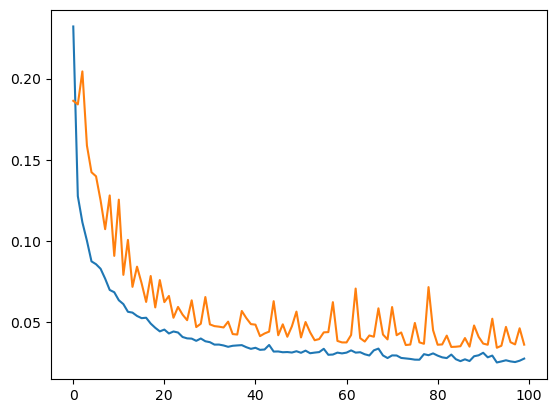

In [77]:
plt.plot(train_rmse)
plt.plot(val_rmse)

In [78]:
with torch.no_grad():
    y_pred = model(X_test)

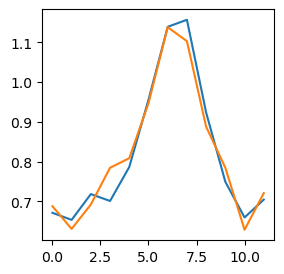

In [79]:
plt.figure(figsize=(3,3)); plt.plot(y_pred[:,0].squeeze())
plt.plot(y_test[:,0].squeeze()); plt.show()

Добавим также возможность проведения численных оценок полученных результатов

In [80]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

def acc_report(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    # r2 = r2_score(y_test, y_pred) * 100
    # print(f"R^2 Error : {r2:.2f}%")    

In [81]:
acc_report(y_test, y_pred)

Root Mean Squared Error (RMSE): 0.036
Mean Absolute Error (MAE): 0.03
Mean Absolute Percentage Error (MAPE): 3.73%


In [82]:
from torchinfo import summary
summary(model, X_train.shape, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [108, 1]                  --
├─Linear: 1-1                            [108, 32]                 768
├─Linear: 1-2                            [108, 1]                  33
Total params: 801
Trainable params: 801
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.09
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.04

### Задание.


**1.** График функции потерь позволяет предположить, что следовало бы остановиться раньше, чем это указано. Определить оптимальное место остановки можно несколькими путями. Например, сохраняя лучшую эпоху и по критерию выхода обучения на плато (например, разность лоссов меньше порога). Последний путь называется `early stop`. Предлагается реализовать этот путь самостоятельно.

**2.** Помимо лосс-функции, часто полезно замерять и другие метрики, например, абсолютное отклонение предсказываемых значений от реальных ($|y - \hat y|$). Эта метрка называется `Mean Absolute Error (MAE)`. Предлагается реализовать эту метрику и ее замеры самостоятельно.

Отметим, что процедуру `early stop` правильней выполнять по метрикам, а не по значениям функции потерь. Поэтому предлагаем также поменять процедуру, используя реализованную метрику.

> __2.1.__ Также важно отметить, что в рассматриваемом примере `MAE` может выступать и в качестве функции потерь. Однако соответствие метрики и функции потерь имеет место далеко не всегда. Более того чаще используют функцию потерь [`Huber Loss`](https://pytorch.org/docs/stable/generated/torch.nn.HuberLoss.html) (также известную как `SmoothL1Loss`) вместо `MAE`, так как она лучше ведет себя в районе небольших значений. Слушатель может проверить эти функции потерь самостоятельно.

**3.** Для более подробного контроля за обучением следует замерять средний лосс и его разброс. Часто снижение разброса говорит о переобучении модели. Предлагаем реализовать замеры среднего и разброса на тренировочной выборке.
> Дополнительно предлагается попробовать довести модель до переобучения и проследить за поведением разброса и среднего.

**4.** Настройка параметров обучения модели (гиперпараметров), а также оптимизатора и других специфических настроек обучения представляет собой сложную задачу, которая требует опыта и времени на работу с моделью. Часто в отсуствии времени рекомендуется использование оптимизатора `Adam`, однако если времени для экспериментов достаточно, то, вероятно, лучшим выбором окажется `SGD with Momentum`. В некоторых случаях, например, если данные сильно зашумлены, лучшим выбором может быть оптимизатор `RMSProp`. Могут быть даны и другие рекомендации. 

Предлагаем слушателю убедиться в различиях сходимости разных оптимизаторов. Например, проверить выше названные, возможно, и другие для изучаемой проблемы предсказания.

**5.** Проверьте, как обучится модель, если ее обучать сразу для $4$ шагов вперед? А как, если отдельно обучить две модели — предсказывающие, соответственно, на $1$-й и на $2$-й шаги?

**6.** На самом деле для получения более точной оценки метрик используется кросс-валидация методом `k-folds`. В случае табличных данных подразумевает, что выборка делится на подвыборки-блоки (`folds`) таким образом, что $k-1$ выборок становятся тренировочной выборкой и один фолд — валидационной. Затем по результатам всех $k$ экспериментов вычисляются средние метрики. Однако, если данные принципиально последовательны, то такой подход не работает. В данных, имеющих заданную последовательность, валидационным может быть только участок, следующий за тренировочным (но не обязательно сразу следующий). Поэтому в данных типа временные ряды используются несколько стратегий. Описанные стратегии называются `backtesting`. Примеры стратегий `backtesting` [показаны ниже](https://joaquinamatrodrigo.github.io/skforecast/0.9.0/user_guides/backtesting.html):

* <img src="https://joaquinamatrodrigo.github.io/skforecast/0.9.0/img/diagram-backtesting-no-refit.png" width="500px" >
* <img src="https://joaquinamatrodrigo.github.io/skforecast/0.9.0/img/diagram-backtesting-refit.png" width="500px" >
* <img src="https://joaquinamatrodrigo.github.io/skforecast/0.9.0/img/diagram-backtesting-refit-fixed-train-size.png" width="500px" >

> Отметим, что оценки методом `k-folds` проводятся для повышения качества (производительности) модели. Например это необходимо для более обоснованного сравнения моделей. 

Предлагается слушателю реализовать любую из указанных стратегий `backtesting` самостоятельно

## Рекуррентная ячейка

При анализе полученной таблицы можно заметить. что каждая ее следующая запись включает в себя информацию из предыдущей записи. Таким образом получается, что все записи связаны заданным порядком следования. В таком случае кажется полезным использовать информацию из предыдущей записи в процессе обработки последующей. Такой принцип можно сравнить в некотором смысле с памятью. 

На практике память может быть реализована в ячейке, называемой `RNN (Recurrent Neural Network)`. В самом простом случае `RNN` соответствует т.н. сети Джордона.


Сеть имеет Джордона имеет следующий вид:

$
h_t = \sigma_h(W_h x_t+U_h h_{t-1}+b_h)$

$ 
y_t =\sigma_y(W_y h_t + b_y)$
где $\sigma_h$ и $\sigma_y$ часто представляют $tanh()$.

> Сегодня в [`PyTorch`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) реализован несколько иной вариант ячейки - сеть Элмана вида
> $$ h_t=tanh(x_t W_{ih}^T+b_{ih}+h_{t-1}W_{hh}^T+b_{hh})$$

Иллюстрация работы сети может быть представлена в следующем виде.
<img src="https://i2.wp.com/miro.medium.com/1*7NZJRVHlBd9dcJabJTxWgg.png">

Рекуррентная  сеть в некотором смысле аналогична т. н. *марковской модели*. Это модель, подразумевающая, что есть некоторая статистическая закономерность в изменениях выходной величины в зависимости от входной величины. То есть выходная величина зависит не только от своего текущего значения, но и от того, какой она была до этого. То есть тот же эффект памяти. Другими словами, если есть некоторая система, то ее выходная величина будет определяться не только входными данными, но и изменением состояний самой системы. Такое изменение будем называть скрытым состоянием. Как пример системы можно привести ускоренное движение. Координата движения в каждый следующий момент будет зависеть не только от текущей координаты движения, но и от текущего значения скорости (скорость при наличии ускорения всегда будет разной). В данном примере скорость — это скрытое состояние системы. Скрытое, потому что мы видим только изменение координат системы, а скорость мы не знаем. Мы ее можем только замерять. Если скорость будет меняться стохастически (то есть с элементами случайности), то движение будет ярким примером марковского процесса. 
На самом деле любую последовательность, имеющую стохастическую природу (будь то текст, временной ряд, речь человека или что-то еще), можно представить в подобном — марковском — виде. В нашем случае результатом представления данных как системы со скрытым состоянием будет возможность переиспользования информации о предыдущем состоянии при определении следующего состояния. Давайте реализуем эту возможность в модели.

<!-- Для реализации рекуррентного механизма добавим к модели соответствующий параметр $W_hh$ и будем рассчитывать не только выходное состояние системы, но и ее скрытое состояние (которое также будет требоваться на вход модели при ее использовании).
Кроме того, заметим, что в нашем случае — упрощенной модели, мы будем использовать квадратные матрицы — скрытый слой будет иметь столько же параметров, как и входной. Более того, поскольку мы работаем с батчем, то скрытое состояние необходимо вычислять для каждой записи из батча. Поэтому батч придется разбить на цикл. Фактически, мы приводим сеть к следующему виду:
$$
x'_t = FC_x(x_t),$$
$$h_{t} = \sigma_h(x'_t+U_h h_{t-1}),$$
$$y_t =FC_y(h_t),
$$
где $t$ - это последовательность записей, а $FC$ - полносвязный слой. -->

Попытаемся инициализировать простейшую рекуррентную нейронную сеть. Эта архитектура будет состоять из:
* `RNN` ячейки, имеющей заданное число слоев `n_layers` заданного размера `hidden_size`;
* Выходного линейного слоя `fc`.
  
<!-- Выходом RNN ячейки могут быть не только предсказанное значение, но и вектор скрытого состояния (точнее, это тензор). Этот тензор может быть подан на вход RNN ячейки в следующей итерации, реализуя принцип памяти. Однако, в силу необходимости ограничить длину контекста (превентивные меры против передачи в состоянии «взрыва» или «вымывания» градиента), периодически скрытое состояние будет переинициализироваться. Поэтому мы будем выводить состояние как второй выход нейронной сети (вторую голову сети, если угодно)./

```python
    class Model(nn.Module):
        def __init__(self, input_size, hidden_size, output_size,num_layers = 1):
            super().__init__()
            self.rnn = nn.RNN(input_size, hidden_size, num_layers =num_layers,  batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
            
        def hidden_state_init(self, batch_size = 1):
            return torch.randn(1, batch_size, 32, requires_grad = True)   
        
        def forward(self, x, h = None):
            if h == None:
                h = self.hidden_state_init(len(x))
            out, h = self.rnn(x, h)
            out = self.fc(out[:, -1, :])
            return out, h
            
    outputs, h = model(X_batch, h)

* in train *
h = h.detach()
``` -->

Отметим, что согласно иллюстрации выше мы будем иметь некоторое предсказание выходной последовательности заданной длины `output_size` для каждого положения скрытого слоя. На деле нас будет интересовать лишь последнее его положение.

Реализация модели приведена ниже

In [83]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layers = 1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers =num_layers,  batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x, hx=None)
        out = self.fc(out[:, -1, :])
        return out

Важно понимать что ячейка предполагает входные данные вида `batch_size, lookback, n_features` (`batch_first=True`) где `lookback` - это число шагов ячейки, а `n_features` - размер окна (`WINDOW`). В полносвязной модели мы использовали входные данные вида `batch_size,  n_features` потому что необходимости в задании "длины контекста"/Глубины памяти у нас небыло. Если было `WINDOW=24` то  теперь давайте представим его как $3$ шага по $8$ записи каждый. Проверим, что это работает.

In [84]:
STEPS_RNN  = 3
WINDOW_RNN = WINDOW//STEPS_RNN

x_test  = X_test.reshape(-1,STEPS_RNN,WINDOW_RNN) 
x_train = X_train.reshape(-1,STEPS_RNN,WINDOW_RNN) 
loader = data.DataLoader(data.TensorDataset(x_train, y_train), shuffle=True, batch_size=BATCH_SIZE,drop_last = True)
x_test.shape, x_train.shape

(torch.Size([12, 3, 8]), torch.Size([108, 3, 8]))

Проведем инициализацию модели.  

In [85]:
input_size = WINDOW_RNN#x_train.shape[2]
learning_rate = 0.01


# Initialize the model, loss function, and optimizer
model = Model(input_size, hidden_size = 16, output_size=HORIZON)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


Тепеь запустим процедуру обучения модели

In [86]:
n_epochs = 200
val_rmse   = np.zeros(n_epochs)
train_rmse = np.zeros(n_epochs)


for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        outputs = model(X_batch)
        loss    = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_rmse[epoch] += np.sqrt(loss.item())

    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)
        val_rmse[epoch] = criterion(y_pred[:y_test.shape[0]], y_test)

    if epoch % 10 == 0:
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse[epoch]/len(loader), val_rmse[epoch]))
        



Epoch 0: train RMSE 0.2282, test RMSE 0.1107
Epoch 10: train RMSE 0.0438, test RMSE 0.0094
Epoch 20: train RMSE 0.0369, test RMSE 0.0059
Epoch 30: train RMSE 0.0318, test RMSE 0.0041
Epoch 40: train RMSE 0.0374, test RMSE 0.0084
Epoch 50: train RMSE 0.0292, test RMSE 0.0080
Epoch 60: train RMSE 0.0262, test RMSE 0.0013
Epoch 70: train RMSE 0.0271, test RMSE 0.0011
Epoch 80: train RMSE 0.0323, test RMSE 0.0093
Epoch 90: train RMSE 0.0284, test RMSE 0.0022
Epoch 100: train RMSE 0.0241, test RMSE 0.0039
Epoch 110: train RMSE 0.0216, test RMSE 0.0015
Epoch 120: train RMSE 0.0233, test RMSE 0.0015
Epoch 130: train RMSE 0.0252, test RMSE 0.0043
Epoch 140: train RMSE 0.0263, test RMSE 0.0020
Epoch 150: train RMSE 0.0236, test RMSE 0.0022
Epoch 160: train RMSE 0.0266, test RMSE 0.0045
Epoch 170: train RMSE 0.0229, test RMSE 0.0023
Epoch 180: train RMSE 0.0240, test RMSE 0.0032
Epoch 190: train RMSE 0.0294, test RMSE 0.0071


И попытаемся посмотреть на результаты

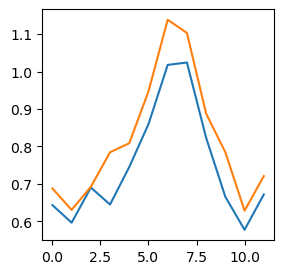

In [87]:
plt.figure(figsize=(3,3)); plt.plot(y_pred.squeeze())
plt.plot(y_test.squeeze()); plt.show()

In [88]:
acc_report(y_test,y_pred)

Root Mean Squared Error (RMSE): 0.081
Mean Absolute Error (MAE): 0.07
Mean Absolute Percentage Error (MAPE): 8.51%


In [89]:
x_train.shape

torch.Size([108, 3, 8])

In [90]:
from torchinfo import summary
summary(model, x_train.shape, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [108, 1]                  --
├─RNN: 1-1                               [108, 3, 16]              416
├─Linear: 1-2                            [108, 1]                  17
Total params: 433
Trainable params: 433
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.14
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.05

### Задание

**1.** Часто по мимо обчной `RNN` ячейки используют ее модификации, обладающие лучшими свойствами при необходимости учета долговременного контекста. К таким ячейкам относятся `LSTM`, `GRU` и другие модификации. В этих модификациях используется два типа памяти - долговременная и кратковременная. В  `GRU`  оба типа памяти учитываются единым вектором (конкатинируются) и модель имеет меньшее число параметров. Предлгааем слушателю запустить обе эти модификации и проверить их работоспособность.

**2.** При использовании рекуррентных ячеек может возникнуть ряд проблем, например, таких как взрыв или вымывание градиента. Это происходит при обучении на длинных последовательностях так как вектор скрытого состояния передается по последовательности. Поэтому проблемы с градиентом в одном положении вектора могут вызвать цепную реакцию во всех его остальных шагах.   Ячейки типа `LSTM` и `GRU` позволяют улучшить ситуацию. Однако, иногда этих мер недостаточно. В качестве дополнительных мер используются следующие:
* ограничение длины контекста;
* ограничение величины градиента (`torch.nn.utils.clip_grad_norm_(model.parameters(), 1)`);
* использование двунаправленных ячеек;
* использование расширенного слоя
* и другие методы.

Предлагаем слушателю самостоятельно разобраться с регулированием длины контекста и ограничением нормы градиента.

__3.__ Иногда имеется необходимость в получение вектора скрытого состояния в явном виде. Этот вектор может быть например  передан между батчами вместо того чтобы использовать в каждом батче свое скрытое состояние. Для этого выход `RNN` ячейки содержит два тензора - предсказанное значение и  скрытое состояние. В примере выше мы не использовали скрытое состояние. Ниже показан пример явного использования скрытого состояния. Обратите внимание в примере на то, что описанная модель имеет теперь два выхода `out, hx` и два входа `x, hx`. Скрытое состояние `hx = None` объявляется перед началом обучения. В ходе обучения, когда `hx` возвращается, то проводится дополнительная операция `hx = hx.detach()`. Эта операция позволяет выводить вектор из градиента - то есть получить только его значене. Эта операция отсутствует на этапе оценки модели, так как он проводится в дейтсвии директивы `torch.no_grad()`.

In [91]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layers = 1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers =num_layers,  batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hx = None):
        out, hx = self.rnn(x, hx=hx)
        out = self.fc(out[:, -1, :])
        return out, hx

Epoch 0: train RMSE 0.3708, test RMSE 0.0251
Epoch 10: train RMSE 0.0390, test RMSE 0.0061
Epoch 20: train RMSE 0.0369, test RMSE 0.0018
Epoch 30: train RMSE 0.0332, test RMSE 0.0016
Epoch 40: train RMSE 0.0311, test RMSE 0.0038
Epoch 50: train RMSE 0.0298, test RMSE 0.0018
Epoch 60: train RMSE 0.0265, test RMSE 0.0024
Epoch 70: train RMSE 0.0276, test RMSE 0.0016
Epoch 80: train RMSE 0.0258, test RMSE 0.0038
Epoch 90: train RMSE 0.0248, test RMSE 0.0043
Epoch 100: train RMSE 0.0285, test RMSE 0.0012
Epoch 110: train RMSE 0.0239, test RMSE 0.0018
Epoch 120: train RMSE 0.0263, test RMSE 0.0035
Epoch 130: train RMSE 0.0271, test RMSE 0.0020
Epoch 140: train RMSE 0.0253, test RMSE 0.0022
Epoch 150: train RMSE 0.0245, test RMSE 0.0018
Epoch 160: train RMSE 0.0261, test RMSE 0.0028
Epoch 170: train RMSE 0.0306, test RMSE 0.0074
Epoch 180: train RMSE 0.0243, test RMSE 0.0020
Epoch 190: train RMSE 0.0222, test RMSE 0.0018


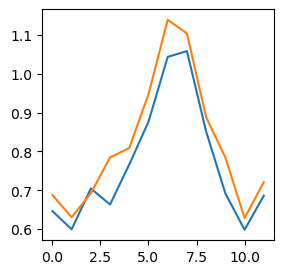

In [92]:
model = Model(input_size, hidden_size = 16, output_size=HORIZON)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 200
#-----------------------------------------
val_rmse   = np.zeros(n_epochs)
train_rmse = np.zeros(n_epochs)
#-----------------------------------------
hx = None
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        outputs, hx = model(X_batch, hx)
        hx = hx.detach()
        loss    = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_rmse[epoch] += np.sqrt(loss.item())

    model.eval()
    with torch.no_grad():
        y_pred, _ = model(x_test, hx)
        val_rmse[epoch] = criterion(y_pred[:y_test.shape[0]], y_test)

    if epoch % 10 == 0:
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse[epoch]/len(loader), val_rmse[epoch]))
#--------------------
plt.figure(figsize=(3,3)); plt.plot(y_pred.squeeze())
plt.plot(y_test.squeeze()); plt.show()

Посуществу постоянное переиспользование `hx` приводит к нарушению принципа ограниченного обучения. Без переиспользования `hx` серия обучения была бы ограничена одним батчем. Явное переиспользование `hx` позволяет ограничивать серию по необходимости. Предлагается слушателю самостоятельно реализовать возможность ограничения серии обучения, например $3$ батчами.

## Сверточная нейронная сеть

На практике часто возникает желание сэкономить общее число параметров модели. Во-первых, это позволяет ускорить обучение, во-вторых, упростить в задачах, где объем обучающей выборки небольшой. Эту операцию можно осуществить если предположить, что полносвязный слой можно заменить на локально-связный. То есть вместо того чтобы рассчитывать каждое значение следующего слоя используя все значения предыдущего мы можем предположить, что на это значение будут влиять только ближайшие к нему значения.

Локальную связть можно представить как некоторое окно, которое будет "скользить" по слою и каждое его положение будет позволять вычислить один результат  - одно значение для следующего слоя. Такую операцию мы называем свертка. Эта операция может быть записана как:
$$
y = K\ast X = \sum_i K\cdot X'_i$$

Где $\ast$ — операция свертки входного тензора $X$ с ядром свертки $K$ меньшего размера. Другими словами, ядро свертки $K$ как-бы скользит по $X$, и в каждом положении происходит операция $\sum K\cdot X'_i$, где $X'_i$ — участок $X$ размером с ядро свертки. 

Таким образом, если в полносвязном слое $W$ должно бы было иметь размеры входного и выходного вектора, чтобы выполнилась операция $XW^T$ то тут  $K$ может быть любым.  Например, в полносвязном слое $dim(W) = 24\times 24$ и $dim(X) = 1\times 24$. Тут же мы можем выбрать ядро свертки $dim(K)=1\times 3$ - размера много меньше, чем $X$, что значительно упростит задачу обучения. Иллюстрация одномерной свертки приведена ниже.

<img src="https://e2eml.school/images/conv1d/aa_copy.gif" style="width:300px">

>  Отметим, что операция $K\ast X$ может привести к изменению размера результата. Для того, чтобы этого не произошло, мы добавляем к $X$ нули справа и слева в нужном количестве (половина размера ядра) - эта операция называется паддинг (`paddig`)./
> На самом деле, сверточный слой редко когда выполняется с одним ядром. На практике считается, что каждое ядро выделяет один признак из входных данных. Поэтому целесообразно использовать несколько сверточных ядер одновременно. В этом состоит некоторое отличие классического определения свертки и сверточного слоя, используемого в нейронных сетях. Особенности сверточного слоя будут рассмотрены в части о компьютерном зрении. 

В приведенном ниже примере мы создали слой одномерной свертки `nn.Conv1d` c ядром `kernel_size = 5`, 1 каналом на входе и 3 каналами на выходе. Свертка реализуется с дополнением входных векторов нуялми в размере `padding = kernel_size//2` c каждой стороны чтобы сохранить общее число параметров на выхде слоя.

Так как указанный слой будет иметь 3-хмерную структуру, то перед тем использовать полносвязный слой мы проведем операцию перегрупперования. То есть из преобразуем 3-х мерный слой в двухмерный (такой, как и ожидается на входе в полносвязный слой).


 

In [93]:
import torch.nn as nn
OUT_CHANNELS = 3
class Model(nn.Module):
    def __init__(self, window = WINDOW, outsize = HORIZON, kernel_size = 5, conv_channels = 3):
        super().__init__()
        self.conv = nn.Conv1d(in_channels  = 1,
                              out_channels = conv_channels,
                              kernel_size  = kernel_size,
                              padding      = kernel_size//2,)
        
        self.out = nn.Linear(window*conv_channels, outsize)
 
    def forward(self, x):

        x = torch.relu(self.conv(x))

        x = x.reshape(x.shape[0],x.shape[1]*x.shape[2])

        x = self.out(x)

        return x

Также будет необходимо трансформировать размеры входной выборки. В данном случае наша выборка будет представлена тензорами, имеющими 1 канал, размером 24 отсчета. Преобразование показано ниже

In [94]:
x_train = X_train.reshape(X_train.shape[0],1,X_train.shape[-1])
x_test  = X_test.reshape(X_test.shape[0],1,X_test.shape[-1])
loader = data.DataLoader(data.TensorDataset(x_train, y_train), shuffle=True, batch_size=BATCH_SIZE,drop_last = True)

x_test.shape, x_train.shape

(torch.Size([12, 1, 24]), torch.Size([108, 1, 24]))

Проверим работоспособность модели

In [95]:
model = Model()

In [96]:
summary(model, x_train.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [108, 1]                  --
├─Conv1d: 1-1                            [108, 3, 24]              18
├─Linear: 1-2                            [108, 1]                  73
Total params: 91
Trainable params: 91
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.05
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.00
Estimated Total Size (MB): 0.07

In [97]:
learning_rate = 0.01

model = Model()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [98]:
n_epochs = 200
val_rmse   = np.zeros(n_epochs)
train_rmse = np.zeros(n_epochs)


for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        outputs = model(X_batch)
        loss    = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_rmse[epoch] += np.sqrt(loss.item())

    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)
        val_rmse[epoch] = criterion(y_pred[:y_test.shape[0]], y_test)

    if epoch % 10 == 0:
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse[epoch]/len(loader), val_rmse[epoch]))

Epoch 0: train RMSE 0.2106, test RMSE 0.0739
Epoch 10: train RMSE 0.0479, test RMSE 0.0028
Epoch 20: train RMSE 0.0406, test RMSE 0.0022
Epoch 30: train RMSE 0.0366, test RMSE 0.0025
Epoch 40: train RMSE 0.0317, test RMSE 0.0029
Epoch 50: train RMSE 0.0286, test RMSE 0.0021
Epoch 60: train RMSE 0.0275, test RMSE 0.0014
Epoch 70: train RMSE 0.0297, test RMSE 0.0022
Epoch 80: train RMSE 0.0251, test RMSE 0.0016
Epoch 90: train RMSE 0.0258, test RMSE 0.0013
Epoch 100: train RMSE 0.0294, test RMSE 0.0017
Epoch 110: train RMSE 0.0247, test RMSE 0.0016
Epoch 120: train RMSE 0.0216, test RMSE 0.0015
Epoch 130: train RMSE 0.0296, test RMSE 0.0016
Epoch 140: train RMSE 0.0225, test RMSE 0.0020
Epoch 150: train RMSE 0.0208, test RMSE 0.0020
Epoch 160: train RMSE 0.0206, test RMSE 0.0018
Epoch 170: train RMSE 0.0211, test RMSE 0.0020
Epoch 180: train RMSE 0.0255, test RMSE 0.0024
Epoch 190: train RMSE 0.0230, test RMSE 0.0020


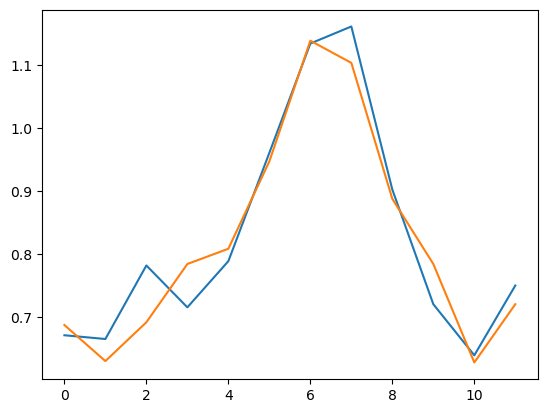

In [99]:
plt.plot(y_pred.squeeze())
plt.plot(y_test.squeeze())

In [100]:
acc_report(y_test,y_pred)

Root Mean Squared Error (RMSE): 0.044
Mean Absolute Error (MAE): 0.04
Mean Absolute Percentage Error (MAPE): 4.57%


### Задание

__1.__ Предлагаем слушателю  провести эксперименты по сравнению общего числа параметров изученных архитектур при решении поставленной задачи. При этом возможно следует провести регулирование числа параметров для реализованных моделей.  

__2.__ Иногда полезным кажется использование последовательности слоев разного типа в одной архитектуре. Предлагается реализовать архитектуру с последовательностью сверточного и рекуррентного слоев и проверить ее точность.

## Блок трансформер

В практике последних лет ($6-7$ лет для текстовой информации и $3-4$ лет для остальных модальностей данных) распространены идеи об использовании единого формата блока (единого подхода) для решения задач. Одним из вероятных кандидатов на применение такого блока является т. н. блок-трансформер.

Идея блока основана на подходе `RNN`, который уже рассматривался. В блоке `RNN` эффект «памяти» реализовывался через передачу одного скрытого состояния, которое модифицировалось на каждом шаге заново. Однако, что если хранить результаты всех скрытых состояний в отдельном массиве. Тогда их все можно использовать с разным весом для того, чтобы более «правильно» влиять на текущий выход нейронной сети. Такая идея называется __идея «внимания»__ (`Attention`). Если на текущий выход нейронной сети будут влиять только скрытые состояния, полученные путем обработки текущего входа, но не предыдущие выходные состояния, то такой подход будет называться __«самовнимание»__ (`Self attention`).
Иллюстрация этой идеи, а также ее сравнение с рассмотренными ранее приведены ниже. 

<img src="https://d2l.ai/_images/cnn-rnn-self-attention.svg">



Концептуально сегодня идея внимания реализуется через т.н. многоголовое внимание типа `QVK Attention`. Однако, в случае `Self Attention` и `QVK` — это одно и тоже. [Иллюстрация подхода приведена ниже](https://theaisummer.com/transformer/).
<img src="https://theaisummer.com/static/56773616d30b9dcb31aa792f2d701276/3096d/key-query-value.png" width="800px">

В оригинале подход `QVK Attention` реализует идею того, что есть некоторый запрос `query` (`Q`). Запрос анализируется на сходство с ключом запроса `key` (`K`). Анализ сходства — это корреляция $QK^T$. Результат этого сходства «взвешивается» при помощи функции `softmax`. Таким образом в запросе выделяется наиболее значимая (коррелирующая с ключом) часть. Другими словами, мы как бы подчеркиваем важную составляющую запроса — то есть обращаем на нее внимание. Результат взвешивания — коэффициенты значимости умножаются на анализируемое значение `value` (`V`). 

В случае самовнимания все три составляющие проецируются из одной и той же выборки. То есть модель выучивает генерацию ключа и запроса, а следовательно, того, на что стоит обращать внимание самостоятельно. 

Отметим, что самовнимание — это не единственный тип внимания. Иллюстрация внимания для разных `QVK` [приведена ниже](https://theaisummer.com/transformer/).

<img src="https://theaisummer.com/static/2e000851b686eb35c6c3c06522437715/26a94/attention-as-database-query.png" width="700px">

Более того, в блоках внимания часто используют т. н. многоголовое внимание. В сущности, это означает, что мы используем отображение входного вектора в пространство такого размера, чтобы его можно было поделить на несколько частей. Для каждой части мы проводим отдельную операцию внимания. Ожидается, что такой подход «как бы» позволяет использовать информацию из входной последовательности в разных блоках «по-разному», то есть мы пытаемся повысить разнообразие. Результаты всех голов затем объединяются. Иллюстрация принципа приведена ниже.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FPrYWZ%2FbtrTGZz0eAH%2FKhrIxmbrDlU8CueeztcEJK%2Fimg.png" width="700px">

Анализ идеи внимания позволяет предположить, что в нем нет необходимости в использовании рекуррентных ячеек как таковых. То есть вместо рекуррентных ячеек можно напрямую использовать блоки внимания и полносвязные блоки. 

В таком случае блок должен иметь следующую структуру.
1. Входная часть (`stream`/`flow`).
    1. Входная последовательность должна представлять собой набор «частей» (`patches`, `tokens`).
    2. Части должны отображаться в вектора заданной размерности (`embeddings`). 
    3. Чтобы как-то не потерять пространственную структуру входных данных, последовательность патчей должна быть помечена (`positional encoding/positional embedding`).
    4. В оригинальной работе к патчам добавляется нулевой патч (`<cls> token`). Ожидается, что этот особый патч должен скопить в себе информацию об обработке всей остальной входной последовательности. Таким образом, например, если входные данные — это последовательность вплоть до заданного момента, то нулевой патч будет предсказанием. Если речь о задаче классификации, то нулевой патч должен содержать информацию о классе.
2. Основной блок. Типичный блок трансформера состоит из следующих частей. 
    1. Слой нормализации (`layer Norm`).
    2. Часть многоголового внимания (`MultiheadAttention`).
    3. Снова слой нормализации и набор полносвязных слоев для каждого патча.
    4. Блок также может содержать дополнительную регуляризацию методом `Dropout`.
    5. Блок также содержит т. н. остаточные связи (`Residual Connection`), которые позволяют модели самой «выучивать», нужна ли та или иная часть блока.
3. Головная часть. Как правило, это полносвязный слой, проецирующий нулевой токен в результат.

Иллюстрация такой архитектуры для изображений приведена ниже.

<img src="https://d2l.ai/_images/vit.svg" width="800px">



Проведем реализацию архитектуры самостоятельно. В архитектуре будет создан:
* слой внимания `nn.MultiheadAttention`, который будет сопровождаться нормализацией и дропаутом.
* Также будет создан полносвязный блок `mlp`, состоящий из двух полносвязных слоев.
* Для встраивания модели создан слой `embedding`.
* Для позиционного кодирования слой `position_encoder`.
* Выход модели задан слоем `fc`.

In [298]:
class transformer_block(nn.Module):

    def __init__(self,input_dim = 8, embed_size = 24, n_pathches = 3, num_heads=2, drop_prob = 0.1):
        super(transformer_block, self).__init__()

        self.attention = nn.MultiheadAttention(embed_size, num_heads, batch_first=True)
       
        self.dropout = nn.Dropout(drop_prob)
        self.ln1 = nn.LayerNorm(embed_size, eps=1e-6)
        self.ln2 = nn.LayerNorm(embed_size, eps=1e-6)
        
        self.mlp = nn.Sequential(nn.Linear(embed_size, 2 * embed_size),
                                nn.LeakyReLU(),
                                nn.Linear(2 * embed_size, embed_size))

        self.embedding = nn.Linear(input_dim,embed_size)        
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))
        
        self.fc = nn.Linear(embed_size,1)

        self.position_encoder = self.positional_encoder(n_pathches, embed_size)
  
    def positional_encoder(self,n_pathches, embed_size):
        return nn.Parameter(torch.randn(n_pathches, embed_size), requires_grad=False)
        
    def forward(self, x):
        # flow
        x = self.embedding(x) 
        x = x + self.position_encoder
        cls_ = self.cls_token.expand([x.shape[0], -1, -1])
        x = torch.cat([cls_, x], axis=1)

        #transformer block part 1
        attn_out, _ = self.attention(x, x, x, need_weights=False)

        x = x + self.dropout(attn_out)
        x = self.ln1(x)
        
        # transformer block part 2
        fc_out = self.mlp(torch.relu(x))

        x = x + self.dropout(fc_out)
        x = self.ln2(x)
        x = torch.relu(x)
        
     
        #cls token only for output
        out = self.fc(x[:, -1, :]) 
        return out
        

In [299]:
# xx = torch.arange(100)
# xx = xx.reshape(5,2,10).transpose(2,1).reshape(5,2,10).reshape(5,10,2).transpose(2,1)
# xx, xx.shape

Модель будет работать с таким же форматом данных, как и для `RNN` архитектуры.

In [300]:
STEPS_RNN  = 3
WINDOW_RNN = WINDOW//STEPS_RNN

x_test  = X_test.reshape(-1,STEPS_RNN,WINDOW_RNN) 
x_train = X_train.reshape(-1,STEPS_RNN,WINDOW_RNN) 
loader = data.DataLoader(data.TensorDataset(x_train, y_train), shuffle=True, batch_size=BATCH_SIZE,drop_last = True)
x_test.shape, x_train.shape

(torch.Size([12, 3, 8]), torch.Size([108, 3, 8]))

In [301]:
model = transformer_block(input_dim=8, embed_size=16)

In [302]:
from torchinfo import summary
summary(model, x_train.shape)

Layer (type:depth-idx)                   Output Shape              Param #
transformer_block                        [108, 1]                  64
├─Linear: 1-1                            [108, 3, 16]              144
├─MultiheadAttention: 1-2                [108, 4, 16]              1,088
├─Dropout: 1-3                           [108, 4, 16]              --
├─LayerNorm: 1-4                         [108, 4, 16]              32
├─Sequential: 1-5                        [108, 4, 16]              --
│    └─Linear: 2-1                       [108, 4, 32]              544
│    └─LeakyReLU: 2-2                    [108, 4, 32]              --
│    └─Linear: 2-3                       [108, 4, 16]              528
├─Dropout: 1-6                           [108, 4, 16]              --
├─LayerNorm: 1-7                         [108, 4, 16]              32
├─Linear: 1-8                            [108, 1]                  17
Total params: 2,449
Trainable params: 2,401
Non-trainable params: 48
Total mult

Проведем обучение созданной модели

In [303]:
input_size = WINDOW_RNN#x_train.shape[2]
learning_rate = 0.01


# Initialize the model, loss function, and optimizer
model = transformer_block(input_dim=input_size, embed_size=16)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [304]:
n_epochs = 200
val_rmse   = np.zeros(n_epochs)
train_rmse = np.zeros(n_epochs)


for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        outputs = model(X_batch)
        loss    = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_rmse[epoch] += np.sqrt(loss.item())

    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)
        val_rmse[epoch] = criterion(y_pred[:y_test.shape[0]], y_test)

    if epoch % 10 == 0:
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse[epoch]/len(loader), val_rmse[epoch]))
        

Epoch 0: train RMSE 0.2949, test RMSE 0.2768
Epoch 10: train RMSE 0.0902, test RMSE 0.0212
Epoch 20: train RMSE 0.0560, test RMSE 0.0066
Epoch 30: train RMSE 0.0492, test RMSE 0.0100
Epoch 40: train RMSE 0.0458, test RMSE 0.0067
Epoch 50: train RMSE 0.0439, test RMSE 0.0128
Epoch 60: train RMSE 0.0391, test RMSE 0.0063
Epoch 70: train RMSE 0.0407, test RMSE 0.0033
Epoch 80: train RMSE 0.0337, test RMSE 0.0071
Epoch 90: train RMSE 0.0368, test RMSE 0.0035
Epoch 100: train RMSE 0.0376, test RMSE 0.0063
Epoch 110: train RMSE 0.0368, test RMSE 0.0056
Epoch 120: train RMSE 0.0315, test RMSE 0.0062
Epoch 130: train RMSE 0.0276, test RMSE 0.0046
Epoch 140: train RMSE 0.0319, test RMSE 0.0050
Epoch 150: train RMSE 0.0270, test RMSE 0.0032
Epoch 160: train RMSE 0.0419, test RMSE 0.0066
Epoch 170: train RMSE 0.0230, test RMSE 0.0066
Epoch 180: train RMSE 0.0321, test RMSE 0.0064
Epoch 190: train RMSE 0.0243, test RMSE 0.0050


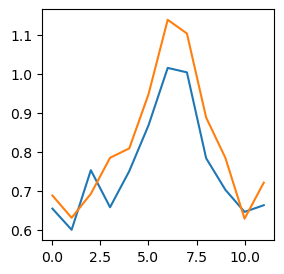

In [311]:
plt.figure(figsize=(3,3)); plt.plot(y_pred.squeeze())
plt.plot(y_test.squeeze()); plt.show()

In [312]:
acc_report(y_test,y_pred)

Root Mean Squared Error (RMSE): 0.081
Mean Absolute Error (MAE): 0.07
Mean Absolute Percentage Error (MAPE): 8.59%


### Задание

__1.__ В данном примере мы использовали набор случайных чисел в качестве `position_encoder`. На самом деле так не делают. Как правило, используются заданные выражения для такого кодирования. В оригинальной работе использовалось кодирование [следующего типа](https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html):
$$\begin{split}\begin{aligned} 
p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\
p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right),
\end{aligned}\end{split}$$
где $p$ — значение кодирования в четных и нечетных индексах $j$; $d$ — размерность вложенного вектора.

In [109]:
def get_positional_embeddings(n_pathches, embed_size):
        result = torch.ones(n_pathches, embed_size)
        i = torch.arange(n_pathches)
     
        for j in range(embed_size):
            result[:,j] = torch.sin(i / (10000 ** (j / embed_size))) if j % 2 == 0 else torch.cos(i / (10000 ** ((j - 1) / embed_size)))
        
        return result

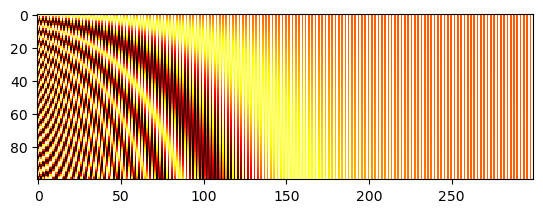

In [110]:
plt.imshow(get_positional_embeddings(100, 300).detach().numpy(), cmap="hot", interpolation="nearest"); plt.show()


Предлагаем слушателю встроить указанный тип кодирования в модель трансформер.

__2.__ В текущей реализации эмбеддинг задан линейным слоем. Однако, иногда его заменяют на сверточный слой. Предлагаем сделать это слушателю самостоятельно.

__3.__ На самом деле для временных рядов до конца не обоснованно введение в архитектуру токена класса. Иногда вместо токена класса выучивается усреднение по остальным выходам трансформера. Предлагаем слушателю реализовать этот вариант. 

<!-- out = self.out_(x.sum(dim = 1))   -->